In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 20

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=0, max_galaxies=1, mean_galaxies = 2, 
                        num_bands=5, num_images=100, brightness=90000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4c006f4358>>
Traceback (most recent call last):
  File "/home/runjing_liu/anaconda3/envs/pytorch_update/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/runjing_liu/anaconda3/envs/pytorch_update/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/runjing_liu/anaconda3/envs/pytorch_update/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/runjing_liu/anaconda3/envs/pytorch_update/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/runjing_liu/anaconda3/envs/pytorch_update/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.g

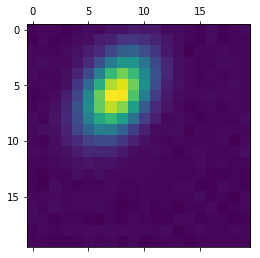

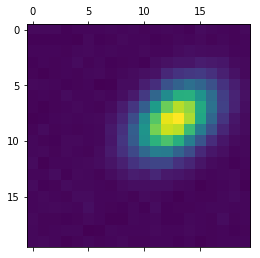

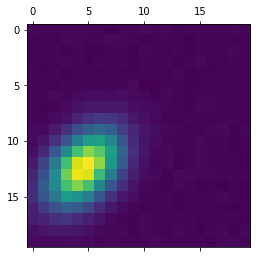

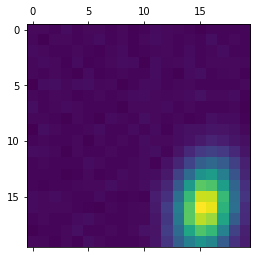

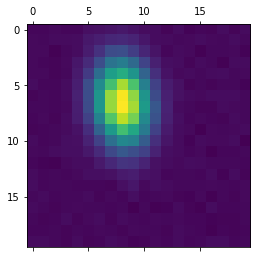

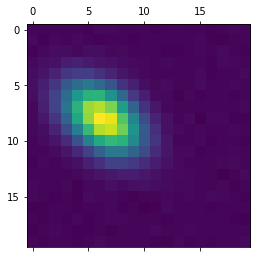

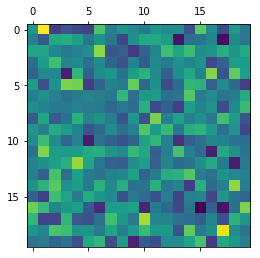

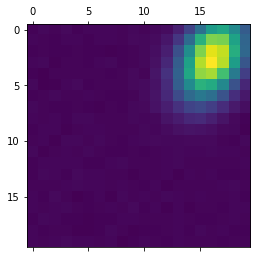

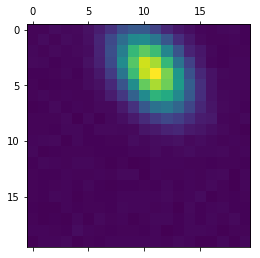

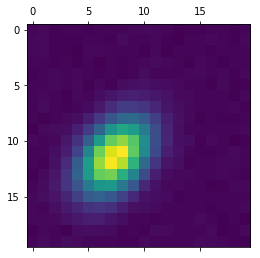

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

load_warm_start_params = False
if load_warm_start_params: 
    state_dict_attn = torch.load('../galaxy_warm_starts/attn_enc_init.dat', map_location='cpu')
    galaxy_vae.attn_enc.load_state_dict(state_dict_attn, strict=False)

    state_dict_enc = torch.load('../galaxy_warm_starts/galaxy_enc_init.dat', map_location='cpu')
    galaxy_vae.enc.load_state_dict(state_dict_enc, strict=False)

    state_dict_dec = torch.load('../galaxy_warm_starts/galaxy_dec_init.dat', map_location='cpu')
    galaxy_vae.dec.load_state_dict(state_dict_dec, strict=False)

In [8]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [10]:
load_from_results = True
if load_from_results: 
    state_dict = torch.load('../galaxy_results_sandbox/topk3/galaxy_vae_topk3_epoch30.dat', map_location='cpu')
    galaxy_rnn.load_state_dict(state_dict, strict = True)

In [11]:
galaxy_rnn.eval(); 
galaxy_rnn.one_galaxy_vae.eval(); 

In [12]:
_, loss = galaxy_rnn.get_pm_loss(image = images_batch1, 
                                    image_so_far = backgrounds_batch1, 
                                    var_so_far = backgrounds_batch1, 
                                    alpha = 0.0, 
                                    topk = 0, 
                                    use_baseline = False)

print(loss)

tensor(97817.0703)


In [13]:
galaxy_lib.train_epoch(galaxy_rnn, train_loader,
            alpha = 0.0,
            topk = 0,
            use_baseline = False,
            train = False)

tensor(1.00000e+05 *
       3.1860)

In [14]:
pixel_probs = galaxy_rnn.get_pixel_probs(resid_image = images_batch1 - backgrounds_batch1, 
                                         var_so_far = backgrounds_batch1)

In [15]:
torch.max(pixel_probs, dim = 1)

(tensor([ 0.2527,  0.2378,  0.5792,  0.3293,  0.1917,  0.3741,  0.4569,
          0.6417,  0.3946,  0.2052]),
 tensor([  14,   44,   84,  144,   15,   37,  144,   10,    6,   86]))

(array([136.,   4.,   1.,   0.,   1.,   0.,   0.,   2.,   0.,   1.]),
 array([1.69054613e-06, 2.37793923e-02, 4.75570941e-02, 7.13347959e-02,
        9.51124977e-02, 1.18890199e-01, 1.42667901e-01, 1.66445603e-01,
        1.90223305e-01, 2.14001007e-01, 2.37778708e-01]),
 <a list of 10 Patch objects>)

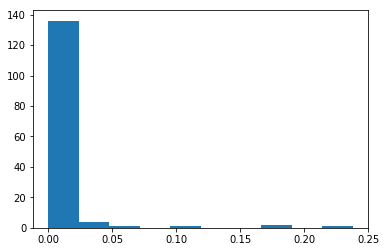

In [16]:
plt.hist(pixel_probs[1, :].detach())

In [17]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [18]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(images_batch1 - backgrounds_batch1,
                                                                     backgrounds_batch1, 
                                                                     backgrounds_batch1, 
                                                                     map_pixel_loc)

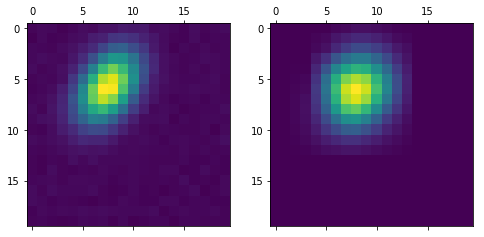

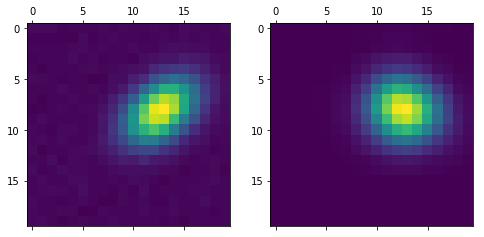

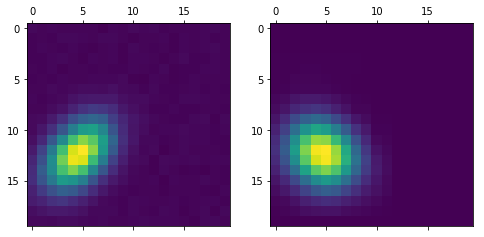

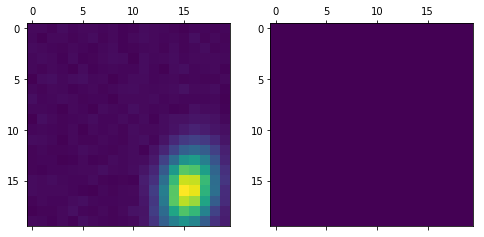

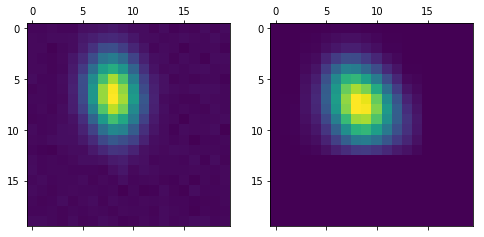

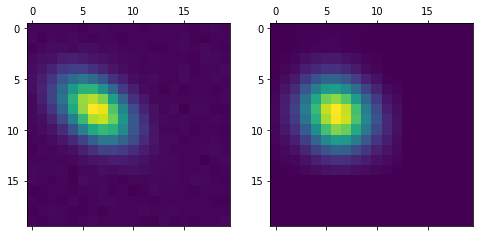

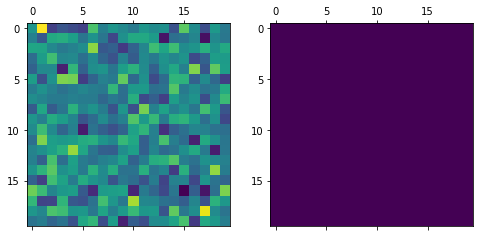

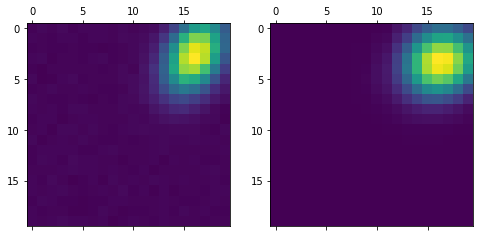

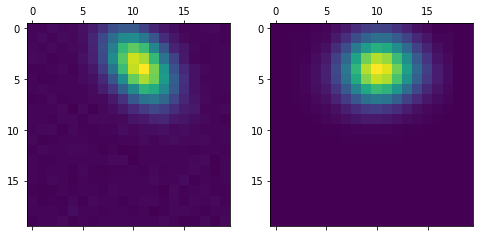

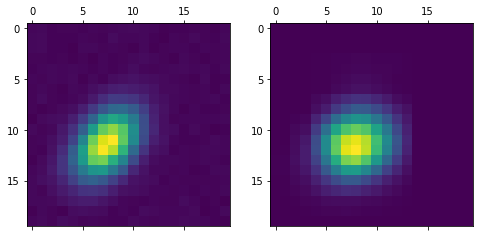

In [19]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())
